In [1]:
import torch
import torchvision

In [2]:
use_cuda = torch.cuda.is_available()
use_cuda

True

In [3]:
import torch.nn as nn

# 定义网络

In [4]:
class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()
        self.layer_1 = Conv3(in_channels, 64)
        self.layer_2 = Conv3(64, 128)
        self.layer_3 = Conv3(128, 256)
        self.layer_4 = Conv3(256, 512)
        self.layer_5 = Conv3(512, 1024)
        self.maxpool = nn.MaxPool2d(2)
        self.layer_4_up = UpConv(1024, 512)
        self.layer_3_up = UpConv(512, 256)
        self.layer_2_up = UpConv(256, 128)
        self.layer_1_up = UpConv(128, 64)
        self.conv1 = nn.Conv2d(64, out_channels, 1)
    
    def forward(self, x):
        x1 = self.layer_1(x)
        x2 = self.maxpool(x1)
        x2 = self.layer_2(x2)
        x3 = self.maxpool(x2)
        x3 = self.layer_3(x3)
        x4 = self.maxpool(x3)
        x4 = self.layer_4(x4)
        x5 = self.maxpool(x4)
        x5 = self.layer_5(x5)
        
        x = self.layer_4_up(x5, x4)
        x = self.layer_3_up(x, x3)
        x = self.layer_2_up(x, x2)
        x = self.layer_1_up(x, x1)
        x = self.conv1(x)
        return torch.sigmoid(x)


class Conv3(nn.Module):
    """
    each conv3 op consist (Conv2d, ReLU)*2
    """
    def __init__(self, in_channels, out_channels):
        super(Conv3, self).__init__()
        self.op = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1), # padding so size don't change
            nn.BatchNorm2d(out_channels), # add BN for stabling training
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x):
        x = self.op(x)
        return x

class UpConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UpConv, self).__init__()
        self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, 2, stride=2)
        self.conv = Conv3(in_channels, out_channels)
        
    def forward(self, x1, x2):
        x1 = self.up(x1)
        # x2.resize_(x1.size()) # crop ?
        x = torch.cat([x2, x1], dim=1) # dim=1 means cat in channels
        x = self.conv(x)
        return x
        

In [5]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os

%matplotlib inline

In [6]:
!pwd

/home/cyb/Code/unet-master


# 加载数据

In [6]:
img_dir = './data/membrane/train/image'
label_dir = './data/membrane/train/label'

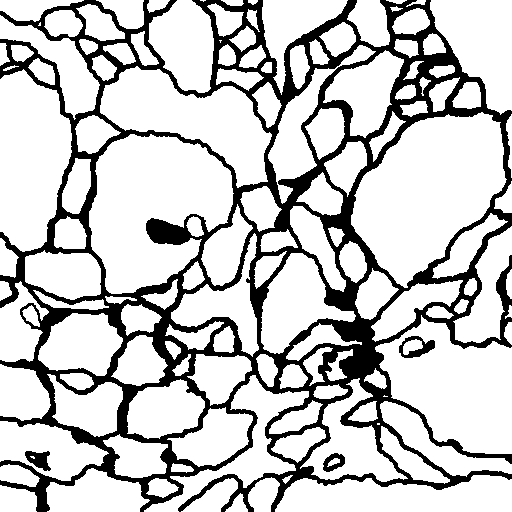

In [7]:
sample = Image.open(os.path.join(img_dir, '0.png'))
label = Image.open(os.path.join(label_dir, '0.png'))
label

In [8]:
label_mask = np.array(label) == 0
label_mask

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [9]:
from torchvision import datasets

## 先储存为numpy数组

In [20]:
img_file_name = os.listdir(img_dir)
train_data = [Image.open(os.path.join(img_dir, f)) for f in img_file_name]
train_data = [np.array(data) for data in train_data] # a list of numpy array
train_data = np.array(train_data, dtype=np.float32)
# train_data.shape : (30, 512, 512)
train_data[0]

array([[156., 185., 201., ..., 165., 162., 160.],
       [164., 201., 206., ..., 146., 141., 150.],
       [174., 196., 208., ..., 147., 159., 160.],
       ...,
       [164., 163., 178., ..., 248., 252., 246.],
       [164., 162., 187., ..., 250., 254., 249.],
       [177., 175., 200., ..., 252., 252., 251.]], dtype=float32)

In [11]:
label_file_name = os.listdir(img_dir)
labels = [Image.open(os.path.join(label_dir, f)) for f in label_file_name]
labels = [np.array(data) for data in labels]
labels = np.array(labels)
labels_mask = labels == 0
labels_mask = labels_mask.astype(np.float32)
labels_mask[0]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [12]:
from torch import optim

In [13]:
train_data[0].shape, labels_mask[0].shape

((512, 512), (512, 512))

# 训练

In [17]:
epochs = 5
lr = 0.1
model = UNet(in_channels=1, out_channels=1)
if use_cuda:
    model = model.cuda()

optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.1, weight_decay=5e-4)
loss_fn = nn.BCELoss(reduction='mean')

H, W = train_data[0].shape

model.train()
for epoch in range(epochs):
    inds = torch.randperm(len(train_data))
    print('epoch {}'.format(epoch))
    for idx in inds:
        data = torch.from_numpy(train_data[idx]).view(1, 1, H, W)
        mask = torch.from_numpy(labels_mask[idx])
        
        if use_cuda:
            data = data.cuda()
            mask = mask.cuda()
        pred = model(data)
        pred = pred.view(-1)
        mask = mask.view(-1)
        # print(mask.dtype, mask[:5])
        loss = loss_fn(pred, mask)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        pred_mask = pred > 0.5
        acc = torch.sum(pred_mask == mask.byte()).item() / len(pred_mask)
        print('loss: {:.4f}, acc: {:.4f}'.format(loss, acc))

epoch 0
loss: 0.6828, acc: 0.5720
loss: 0.5965, acc: 0.8102
loss: 0.5655, acc: 0.7795
loss: 0.5246, acc: 0.8202
loss: 0.4916, acc: 0.8301
loss: 0.4582, acc: 0.8517
loss: 0.4637, acc: 0.8194
loss: 0.4541, acc: 0.8052
loss: 0.4324, acc: 0.8206
loss: 0.4006, acc: 0.8614
loss: 0.3948, acc: 0.8552
loss: 0.3983, acc: 0.8328
loss: 0.3786, acc: 0.8418
loss: 0.3733, acc: 0.8530
loss: 0.3635, acc: 0.8584
loss: 0.3728, acc: 0.8348
loss: 0.3925, acc: 0.8215
loss: 0.3683, acc: 0.8342
loss: 0.3765, acc: 0.8279
loss: 0.3729, acc: 0.8196
loss: 0.3485, acc: 0.8506
loss: 0.3427, acc: 0.8517
loss: 0.3380, acc: 0.8609
loss: 0.3148, acc: 0.8681
loss: 0.3432, acc: 0.8458
loss: 0.3168, acc: 0.8713
loss: 0.3004, acc: 0.8869
loss: 0.3167, acc: 0.8583
loss: 0.3097, acc: 0.8699
loss: 0.3244, acc: 0.8594
epoch 1
loss: 0.3067, acc: 0.8719
loss: 0.3148, acc: 0.8647
loss: 0.2929, acc: 0.8805
loss: 0.3609, acc: 0.8292
loss: 0.3068, acc: 0.8711
loss: 0.3169, acc: 0.8557
loss: 0.2885, acc: 0.8785
loss: 0.3047, acc: 0.8

# 预测

(512, 512)


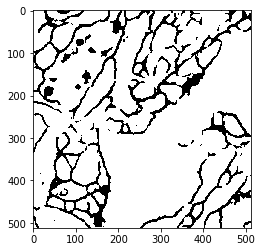

In [19]:
model.eval()
model = model.cpu()
test_sample = Image.open('./data/membrane/test/0.png')
plt.imshow(test_sample)
test_sample = np.array(test_sample, dtype=np.float32)
test_sample = torch.from_numpy(test_sample)
test_sample = test_sample.view(1, -1, 512, 512)
pred = model(test_sample)
pred_mask = pred > 0.5
pred_img = pred_mask.squeeze().numpy()
print(pred_img.shape)
mask = pred_img == 1
pred_img[mask] = 0
pred_img[~mask] = 255
plt.imshow(pred_img, cmap=plt.cm.gray)

# 对比别人的预测

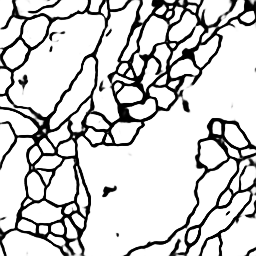

In [21]:
test_result = Image.open('./data/membrane/test/0_predict.png')
test_result